## Overview

We characterize the performance of the use case of Alchemlyb, python library with the following configurations, 1) number of files, 2) number of directories (concurrency) and 3) file sizes. This helps us understand the scalability and overhead if exists.

## Parameters

- Number of Files
- Number of Directories
- Size of Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

## Elapsed Time as a function of the number of files

This experiment isn't running concurrent but is instead sequential with file I/O. The result demonstrates the extra stresses generated by increased number of files to process on a parallel file system, Luster.

Experiment setup
- non-parallel exection
- 2MB uniform file size
- N number of files in a single directory

Text(0,0.5,u'Elapsed Time (s)\n(TTX)')

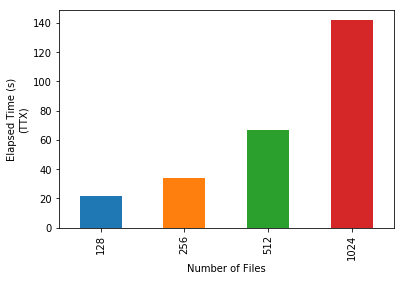

In [13]:
fname='logs/nfiles.1024.log'
df1024 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.512.log'
df512 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.256.log'
df256 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.128.log'
df128 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])

df1024 = df1024.assign(nfiles=1024)
df512 = df512.assign(nfiles=512)
df256 = df256.assign(nfiles=256)
df128 = df128.assign(nfiles=128)
df = pd.concat([df128,df256,df512,df1024])
df = df.assign(parsing_time=df.elapsed_time - df['_extract_state'] - df['_extract_dataframe'])
df = pd.DataFrame([[128, df128.elapsed_time.sum(), df128._extract_state.sum(), df128._extract_dataframe.sum(), df128.elapsed_time.sum()- df128._extract_state.sum()- df128._extract_dataframe.sum()],
                      [256, df256.elapsed_time.sum(),  df256._extract_state.sum(), df256._extract_dataframe.sum(), df256.elapsed_time.sum()-  df256._extract_state.sum()- df256._extract_dataframe.sum()],
                       [512, df512.elapsed_time.sum(), df512._extract_state.sum(), df512._extract_dataframe.sum(), df512.elapsed_time.sum()- df512._extract_state.sum()- df512._extract_dataframe.sum()],
                       [1024,df1024.elapsed_time.sum(),  df1024._extract_state.sum(), df1024._extract_dataframe.sum(), df1024.elapsed_time.sum()-  df1024._extract_state.sum()- df1024._extract_dataframe.sum()]]
                      ,columns=['nfiles', 'elapsed_time', 'extract_state', 'extract_dataframe', 'parsing_time'])

fig, axes = plt.subplots(1,1)
df.plot.bar('nfiles', 'elapsed_time', legend=False, ax=axes)
axes.set_xlabel('Number of Files')
axes.set_ylabel("Elapsed Time (s)\n(TTX)")

### Proportion of Elapsed Time between I/O and non-I/O

$$Elapsed Time = Time of Parsing Header + Time of Parsing Body + Time of Converting to Pandas DataFrame$$

In alchemlyb, two functions open files and read lines to parse a header and body, which are described as header/body I/O in the following plot. 

- _extract_state: parsing header
- _extract_dataframe: parsing body

Text(0.5,0,u'Number of Files')

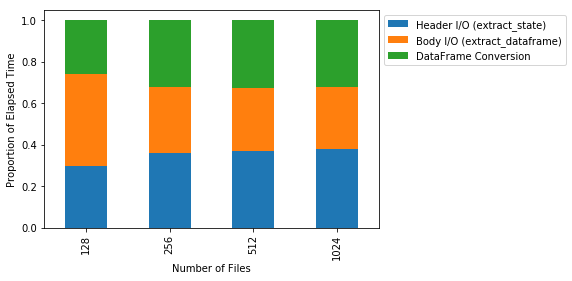

In [23]:
df = df[['nfiles','extract_state', 'extract_dataframe', 'parsing_time']]
d1=df.extract_state/(df.extract_state + df.extract_dataframe + df.parsing_time)
d2=df.extract_dataframe/(df.extract_state + df.extract_dataframe + df.parsing_time)
d3=df.parsing_time/(df.extract_state + df.extract_dataframe + df.parsing_time)
d=pd.concat([d1,d2,d3], axis=1)
fig, axes = plt.subplots(1,1)
d.plot.bar(stacked=True, ax=axes)
axes.legend(['Header I/O (extract_state)','Body I/O (extract_dataframe)', 'DataFrame Conversion'],loc='top left', bbox_to_anchor=(1, 1.0))
axes.set_xticklabels([128,256,512,1024])
axes.set_ylabel('Proportion of Elapsed Time')
axes.set_xlabel('Number of Files')

### Distribution with I/O (in detail)

Text(0.5,0.98,u'Boxplot grouped by number of files')

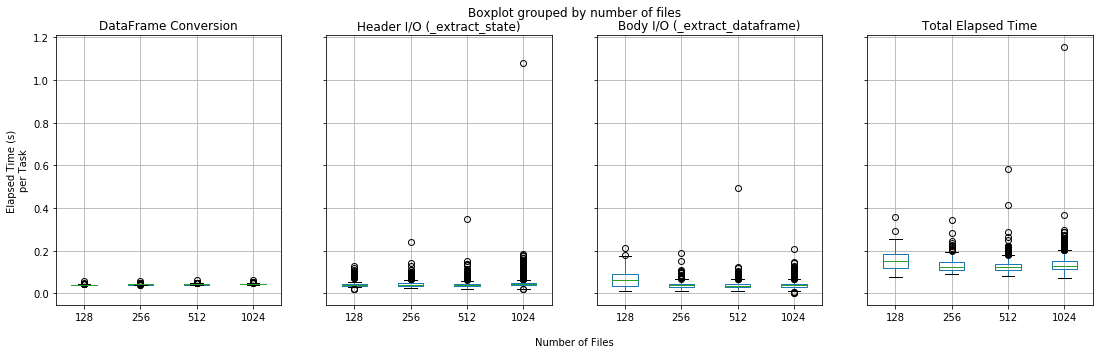

In [12]:
fname='logs/nfiles.1024.log'
df1024 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.512.log'
df512 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.256.log'
df256 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])
fname='logs/nfiles.128.log'
df128 = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','_extract_state','_extract_dataframe','start_time','end_time'])

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

df1024 = df1024.assign(nfiles=1024)
df512 = df512.assign(nfiles=512)
df256 = df256.assign(nfiles=256)
df128 = df128.assign(nfiles=128)
df = pd.concat([df128,df256,df512,df1024])
df = df.assign(parsing_time=df.elapsed_time - df['_extract_state'] - df['_extract_dataframe'])
df.boxplot(column=['parsing_time'],by='nfiles', ax=axes[0])
df.boxplot(column=['_extract_state'],by='nfiles', ax=axes[1])
df.boxplot(column=['_extract_dataframe'],by='nfiles', ax=axes[2])
df.boxplot(column=['elapsed_time'],by='nfiles', ax=axes[3])
axes[0].set_title('DataFrame Conversion')
axes[0].set_ylabel('Elapsed Time (s)\nper Task')
axes[1].set_title('Header I/O (_extract_state)')
axes[2].set_title('Body I/O (_extract_dataframe)')
axes[3].set_title('Total Elapsed Time')
for i in range(4):
    axes[i].set_xlabel('')
fig.text(0.5, 0.04, 'Number of Files', ha='center')
#fig.text(0.04, 0.5, 'Elapsed Time (s)', va='center', rotation='vertical')
fig.suptitle('Boxplot grouped by number of files')

## Elapsed Time as a function of the number of directories

The simulation data are divided in multiple directories and we run them like embarrassingly parallel tasks using Dask distributed framework.

Experiment setup
- 128 concurrent workers (128 processes) 
   - i.e. 6 compute nodes on XSEDE Comet
- 10 files each directory
   - with different file sizes between 2 and 10MB

The number of directories is same with the number of simulations in this use case.

Text(0.5,-0.05,u'Number of Directories')

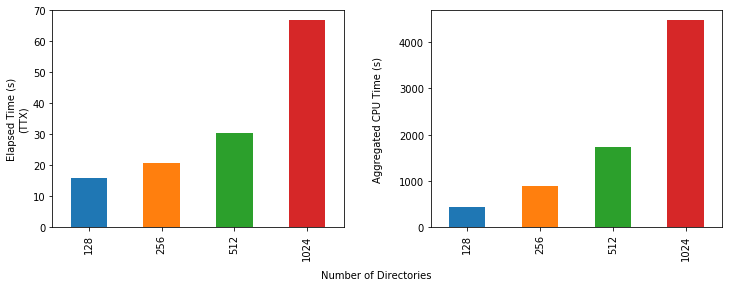

In [11]:
fname='logs/ndirs.total.all.log'
df_ndirs = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','sim','file_count','throughput','elapsed_time','file_size','start_time','end_time', 'opt1','opt2'])

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)
walltime_ndirs =df_ndirs.groupby(['opt1']).end_time.max() - df_ndirs.groupby(['opt1']).start_time.min()
cputime_ndirs = df_ndirs.groupby(['opt1']).elapsed_time.sum()
walltime_ndirs.plot.bar(ax=axes[0])
cputime_ndirs.plot.bar(ax=axes[1])
axes[0].set_ylabel('Elapsed Time (s)\n(TTX)')
axes[1].set_ylabel('Aggregated CPU Time (s)\n')
for i in range(2):
    axes[i].set_xlabel('')
fig.text(0.5, -0.05, 'Number of Directories', ha='center')
#fig.text(0.07, 0.5, 'Elapsed Time (s)', va='center', rotation='vertical')

### Distribution with I/O (in detail)

Text(0.5,0.98,u'Boxplot grouped by number of directories')

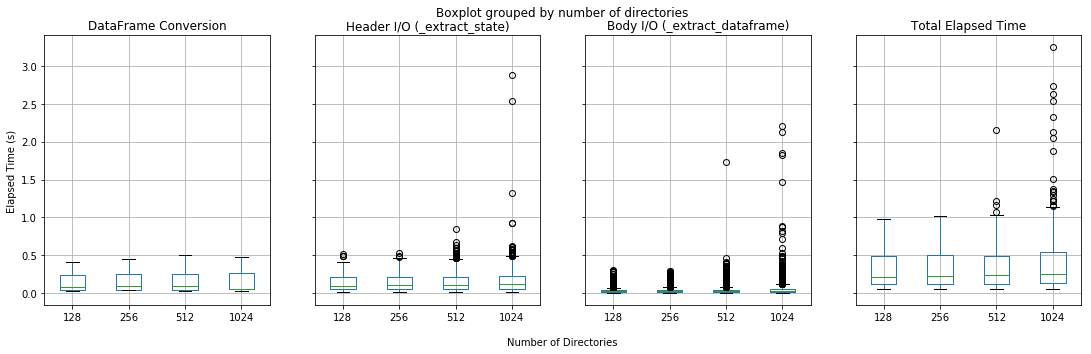

In [6]:
fname='logs/ndirs.extract_dataframe.all.log'
df_ndirs_detail = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','sim','file_name','throughput','elapsed_time','file_size','start_time','end_time', 'opt1','opt2'])
# opt1: _extract_state
# opt2: _extract_dataframe without pd.DataFrame conversion
df_ndirs_detail = df_ndirs_detail.assign(ndirs=pd.Series([int(x[9]) for x in df_ndirs_detail.file_name.str.split('/')]))

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

df_ndirs_detail = df_ndirs_detail.assign(parsing_time=df_ndirs_detail.elapsed_time - df_ndirs_detail['opt1'] - df_ndirs_detail['opt2'])
df_ndirs_detail.boxplot(column=['parsing_time'],by='ndirs', ax=axes[0])
df_ndirs_detail.boxplot(column=['opt1'],by='ndirs', ax=axes[1])
df_ndirs_detail.boxplot(column=['opt2'],by='ndirs', ax=axes[2])
df_ndirs_detail.boxplot(column=['elapsed_time'],by='ndirs', ax=axes[3])
axes[0].set_title('DataFrame Conversion')
axes[0].set_ylabel('Elapsed Time (s)')
axes[1].set_title('Header I/O (_extract_state)')
axes[2].set_title('Body I/O (_extract_dataframe)')
axes[3].set_title('Total Elapsed Time')
for i in range(4):
    axes[i].set_xlabel('')
fig.text(0.5, 0.04, 'Number of Directories', ha='center')
fig.suptitle('Boxplot grouped by number of directories')

## Elapsed Time as a function of the file sizes

We see linear scalability on increase file sizes under 32MB and the comutations are divided between I/O and CPU for DataFrame conversion. 

Experiment Setup
- 128 concunrent workers
- Uniform directory counts (128) with 10 files each

Text(0,0.5,u'Aggregated CPU Time (s)')

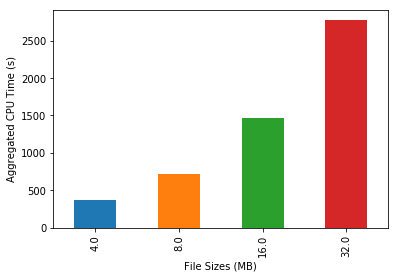

In [9]:
fname='logs/fsizes.all.log'
df_fsizes = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','sim','filename','throughput','elapsed_time','file_size','start_time','end_time','fsizes'])

fig, axes = plt.subplots(1,1)
df_fsizes[df_fsizes.type=='total'].groupby('fsizes')['elapsed_time'].sum().plot.bar(ax=axes)
axes.set_xlabel('File Sizes (MB)')
axes.set_ylabel("Aggregated CPU Time (s)")

### Distribution with I/O (in detail)

Text(0.5,0.98,u'')

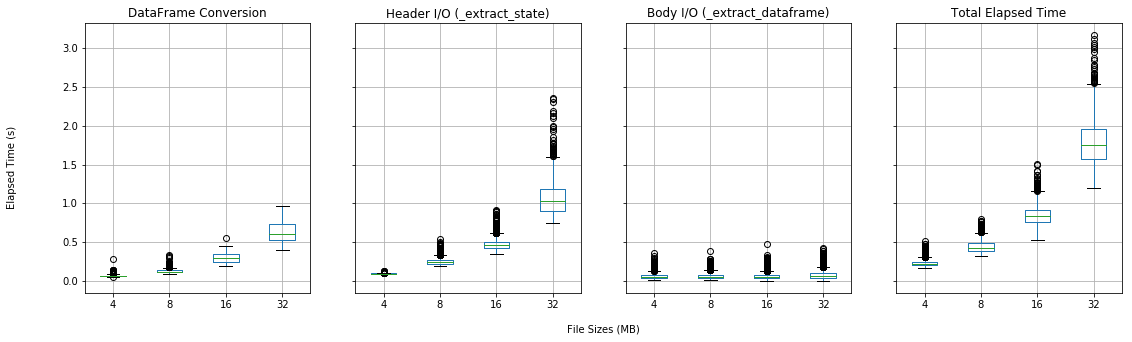

In [8]:
fname='logs/fsizes.all.extract_dataframe.log'
df = pd.read_csv(open(fname), sep=",", header=None, names=['function_name','type','filename','elapsed_time','extract_state', 'extract_dataframe','start_time','end_time','fsizes'])

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)

df = df.assign(parsing_time=df.elapsed_time - df['extract_state'] - df['extract_dataframe'])
df.boxplot(column=['parsing_time'],by='fsizes', ax=axes[0])
df.boxplot(column=['extract_state'],by='fsizes', ax=axes[1])
df.boxplot(column=['extract_dataframe'],by='fsizes', ax=axes[2])
df.boxplot(column=['elapsed_time'],by='fsizes', ax=axes[3])
axes[0].set_title('DataFrame Conversion')
#axes[0].set_ylabel('Elapsed Time (s)')
axes[1].set_title('Header I/O (_extract_state)')
axes[2].set_title('Body I/O (_extract_dataframe)')
axes[3].set_title('Total Elapsed Time')
for i in range(4):
    axes[i].set_xlabel('')
fig.text(0.5, 0.04, 'File Sizes (MB)', ha='center')
fig.text(0.04, 0.5, 'Elapsed Time (s)', va='center', rotation='vertical')
fig.suptitle('')